In [ ]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.clust_utils import pad_symmetric
import torch
from torch.utils.data import DataLoader, TensorDataset
from src.training.models import CNNResNetAttention
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
from src.clust_utils.static import ALGORITHMS
from tqdm import tqdm
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [2]:
ari_scores = np.load("../data/test/ari_scores.npy", allow_pickle=True)
dataset = np.load("../data/test/features.npy", allow_pickle=True)
ari_binary = [(np.array(ari) > 0.8).astype(int) for ari in ari_scores]
y_true = np.concatenate(ari_binary).reshape(-1, 10)

In [ ]:
# Load Models:
cnnresatt_model = CNNResNetAttention()
cnnresatt_model.load_state_dict(torch.load('../artifacts/models/cnnresatt.pth', map_location=device))
cnnresatt_model.to(device)
cnnresatt_model.eval()

# Batch Data
all_X_padded = []
all_true_ari = []

padded_X = {}

for i in tqdm(range(len(dataset))):
    data_i = dataset[i]
    ari_i = ari_binary[i]
    padded = pad_symmetric(data_i)
    X_pad = padded[np.newaxis, np.newaxis, :, :]  # → (1, 1, 2000, 50)
    all_X_padded.append(X_pad)
    all_true_ari.append(ari_i[np.newaxis, :])  # → (1, 10)


# Convert to tensors and batch
X_tensor = torch.tensor(np.vstack(all_X_padded)).float()
y_tensor = torch.tensor(np.vstack(all_true_ari)).float()
val_dataset = TensorDataset(X_tensor, y_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Run model on all data
y_pred_model = []
preds = []
with torch.no_grad():
    for x_batch, _ in val_loader:
        x_batch = x_batch.to(device)
        pred = cnnresatt_model(x_batch)  # shape (batch, 10)
        preds.append(pred)  # Store raw predictions for further analysis
        binary_preds = (torch.sigmoid(pred) > 0.5).cpu().numpy() 
        y_pred_model.append(binary_preds)

# Final model predictions 
y_pred_model = np.vstack(y_pred_model)

100%|██████████| 3400/3400 [00:00<00:00, 4205.82it/s]


In [4]:
cm = multilabel_confusion_matrix(y_true, y_pred_model)
cm_perc = np.zeros((10, 2, 2))
for i, item in enumerate(cm):
    cm_perc[i, 0, 0] = item[1, 1] / (item[1, 1] + item[1, 0])
    cm_perc[i, 0, 1] = item[1, 0] / (item[1, 1] + item[1, 0])
    cm_perc[i, 1, 0] = item[0, 1] / (item[0, 0] + item[0, 1])
    cm_perc[i, 1, 1] = item[0, 0] / (item[0, 0] + item[0, 1])

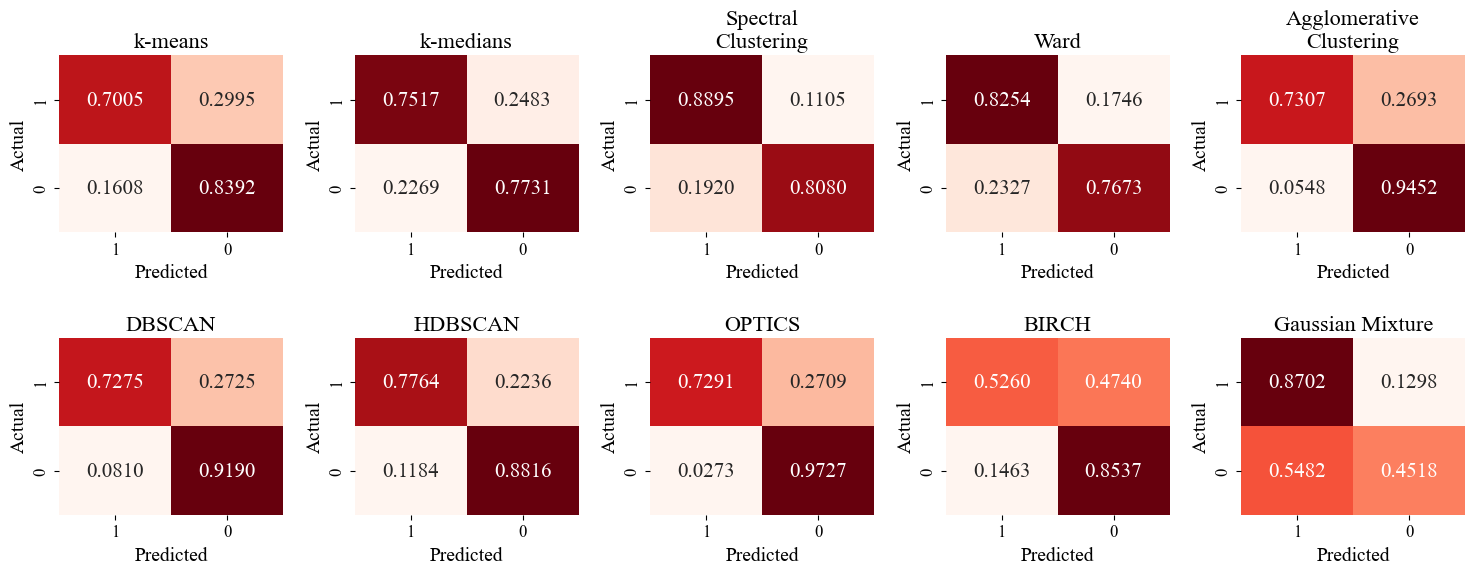

In [5]:
# Set Times New Roman globally and font sizes
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 15,
    'axes.labelsize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'axes.titlesize': 16,
    'legend.fontsize': 13
})


# Plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(len(cm_perc)):
    ax = axes.flat[i]
    sns.heatmap(cm_perc[i],
                annot=True,
                cmap='Reds',
                fmt='.4f',
                cbar=False,
                ax=ax,
                xticklabels=['1', '0'],
                yticklabels=['1', '0'],
                annot_kws={'size': 15},
                )  

    ax.set_title(ALGORITHMS[i].display_name, fontsize=16)
    ax.set_xlabel('Predicted', fontsize=14)
    ax.set_ylabel('Actual', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.6)

# Save with Cairo backend to ensure embedded fonts & PDF/A-friendly output
plt.savefig("../results/fig3_confusion_matrix.pdf", dpi=600, bbox_inches='tight', backend='cairo')
plt.show()
plt.close()